## Data analyses in Camargo 202x

This notebook contain the analyses of response times in Carmargo 202x

In [ ]:
# Observations: Follow the steps in the local path:
# 1. Create the virtual environment: > python -m venv <virtual folder name>
# 2. Activate the virtual environment: > source <virtual folder name>/bin/activate
# 3. pip install -r requirements.txt

In [ ]:
!pip install pingouin

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.4/204.4 kB 4.1 MB/s eta 0:00:00


In [ ]:
# Importing the required packages
import pandas as pd
import xlrd
import numpy as np
from scipy import stats
import seaborn as sns
from matplotlib import pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.anova import AnovaRM
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import pingouin as pg

In [ ]:
# For cloud environment install
# !pip install pingouin

# Access to the files in google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Reading data in the file
excel_sheets = pd.read_excel('/content/drive/MyDrive/advisoring/Patricia/Camargo_Data.xls', sheet_name=None)

In [ ]:
# Reading the sheet with the response times and cleaning datasheet
data_raw = excel_sheets['teste']
data = data_raw[['VOLUNTÁRIO', 'Grupo', 'BLOCO', 'ESTIMULO', 'RESPONSE', 'RT2']]
data = data.rename(columns={"VOLUNTÁRIO": "volunteer", "Grupo":"group", "BLOCO": "block", "ESTIMULO":"stimuli", "RESPONSE": "response", "RT2": "time"})
data

,volunteer,group,block,stimuli,response,time
0,1,1,1,1,1,0.385377
1,1,1,1,2,2,0.160592
2,1,1,1,2,2,0.333033
3,1,1,1,1,1,0.329504
4,1,1,1,2,2,0.255981
...,...,...,...,...,...,...
14995,20,2,5,2,NaN,0.461856
14996,20,2,5,2,NaN,0.579399
14997,20,2,5,1,NaN,0.730679
14998,20,2,5,2,NaN,0.344022


In [ ]:
# Creating the columns for identifying the stimulus type
# types are:
#     - f1
#     - f2
#     - v2
#     - v3
# f stands for fix and v for variable

# declaring variables
p_num = max(data['volunteer'])
stim_type =  list()

# identifying the types
for p in range(1,p_num+1):
    p_data = data.loc[data['volunteer'] == p,:].reset_index(drop=True)
    lines = p_data.shape[0]
    for l in range(lines):
        if p_data['stimuli'][l] == 1:
            stim_type.append('f1')
        elif p_data['stimuli'][l] == 2:
            if l-1 >= 0:
                if p_data['stimuli'][l-1] == 1:
                    stim_type.append('f2')
                else:
                    stim_type.append('v2')
            else:
                if p_data['stimuli'][l+1] == 1:
                    stim_type.append('v2')
                else:
                    stim_type.append('f2')# Comparing groups
        else:
            stim_type.append('v3')

data['stim_type'] = stim_type

In [ ]:
# Calculating the mean reaction time by participant/block/stim_type

parts = list(range(1,p_num+1))
blocks = list(set(data['block']))
stim_labels = sorted(list(set(data['stim_type'])))
exists_df = 0

for p in parts:
    for b in blocks:
        for t in stim_labels:
            p_data = data.loc[ data['volunteer'] == p,: ]
            p_data = p_data.loc[ data['block'] ==  b, : ]
            p_data = p_data.loc[ data['stim_type'] ==  t, :]
            g = 1 if p < 11 else 2
            p_dict = [{'volunteer': p,  'group': g, 'block': b, 'stim_type': t, 'mean_rt': p_data['time'].mean()}]
            if exists_df == 0:
                data_summary1 = pd.DataFrame(p_dict)
                exists_df = 1
            else:
                new_row_df = pd.DataFrame(p_dict)
                data_summary1 = pd.concat([data_summary1, new_row_df], ignore_index=True)




In [ ]:
# Checking the calculations

data_summary1

,volunteer,group,block,stim_type,mean_rt
0,1,1,1,f1,0.314303
1,1,1,1,f2,0.152862
2,1,1,1,v2,0.265676
3,1,1,1,v3,0.817703
4,1,1,2,f1,0.243963
...,...,...,...,...,...
395,20,2,4,v3,0.567417
396,20,2,5,f1,0.596645
397,20,2,5,f2,0.550463
398,20,2,5,v2,0.562662


In [ ]:
# Separating dataframes by group
g1_data_summary = data_summary1.loc[ data_summary1[ 'group'] == 1, : ].drop(columns=['group'])
g2_data_summary = data_summary1.loc[ data_summary1[ 'group'] == 2, : ].drop(columns=['group'])

In [ ]:
# # Visualizing data
# fig, axes = plt.subplots(1, 2, figsize=(10,5))
# sns.boxplot(ax=axes[0], data=g1_data_summary, x="block", y="mean_rt", hue="stim_type")
# axes[0].set(ylim=(0, 1))
# sns.boxplot(ax=axes[1], data=g2_data_summary, x="block", y="mean_rt", hue="stim_type")
# axes[1].set(ylim=(0, 1))

### Performing a repeated measures 2-way ANOVA

The 2-way presents 2 important assumptions:
- Normality test
- Sphericity test

We are going to test the distribution for each of these assumptions.

In [ ]:
# Testing data for normality

# For group 1: block by block

pg.normality(g1_data_summary.loc[g1_data_summary['block'] ==  1, :], dv='mean_rt', group='stim_type', method='shapiro', alpha=0.05)

# Group 1, block 1 failed normality in one of the distributions

,W,pval,normal
stim_type,,,
f1,0.948353,0.649052,True
f2,0.920220,0.358798,True
v2,0.952781,0.701448,True
v3,0.677745,0.000474,False


In [ ]:
# Given the failure in the Normality test, we are going to
# rank-transform the data as indicated by: https://www.cfholbert.com/blog/nonparametric_two_way_anova/

In [ ]:
# Rank transformation of the distributions

# group 1

final_df1 = g1_data_summary.copy()
final_df1['mean_rt'] = stats.rankdata(final_df1['mean_rt'])

# group 2

final_df2 = g2_data_summary.copy()
final_df2['mean_rt'] = stats.rankdata(final_df2['mean_rt'])

In [ ]:
# Peforming the Shapiro-Wilk test for normality of the distributions AGAIN

pg.normality(final_df1.loc[final_df1['block'] ==  5, :], dv='mean_rt', group='stim_type', method='shapiro', alpha=0.05)

# Only one distribution failed the normality test, but not of the level of 0.01

,W,pval,normal
stim_type,,,
f1,0.836679,0.040258,False
f2,0.856083,0.068596,True
v2,0.960068,0.786646,True
v3,0.959152,0.776157,True


In [ ]:
# # Verifying reconstruction with visualization

# # Rank plot group 1
# fig, axes = plt.subplots(2, 2, figsize=(15,8))
# sns.boxplot(ax=axes[0,0], data=final_df1, x="block", y="mean_rt", hue="stim_type")
# axes[0,0].legend(ncol=4,loc='lower center')

# # Rank plot group 2
# sns.boxplot(ax=axes[0,1], data=final_df2, x="block", y="mean_rt", hue="stim_type")
# axes[0,1].legend(ncol=4,loc='lower center')

# # normal plot group 1
# sns.boxplot(ax=axes[1,0], data=g1_data_summary, x="block", y="mean_rt", hue="stim_type")
# axes[1,0].legend(ncol=4,loc='lower center')

# # normal plot group 2
# sns.boxplot(ax=axes[1,1], data=g2_data_summary, x="block", y="mean_rt", hue="stim_type")
# axes[1,1].legend(ncol=4,loc='lower center')

In [ ]:
# Given that pengouin already makes the sphericity test, there is no need to apply it

# Performing 2-way repeated measures ANOVA

# group 1

res_anova1 = pg.rm_anova(data=final_df1, dv='mean_rt', within=['block', 'stim_type'], subject='volunteer', correction='auto', effsize='ng2')

# group 2

res_anova2 = pg.rm_anova(data=final_df2, dv='mean_rt', within=['block', 'stim_type'], subject='volunteer', correction='auto', effsize='ng2')

/usr/local/lib/python3.10/dist-packages/pingouin/distribution.py:515: UserWarning: Epsilon values might be innaccurate in two-way repeated measures design where each  factor has more than 2 levels. Please  double-check your results.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pingouin/distribution.py:515: UserWarning: Epsilon values might be innaccurate in two-way repeated measures design where each  factor has more than 2 levels. Please  double-check your results.
  warnings.warn(


In [ ]:
# Checking the results of the 2-way repeated measures ANOVA

# For group 1: significant effect of stimulus type

res_anova1


# For group 2: significant effect of stimulus type and block

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,block,17066.55,4,36,4266.637500,1.252470,0.306519,0.310718,0.030069,0.702351
1,stim_type,74681.72,3,27,24893.906667,5.569694,0.004157,0.012576,0.119452,0.678284
2,block * stim_type,24379.33,12,108,2031.610833,1.095658,0.371217,0.372086,0.042406,0.305612


In [ ]:
# Checking the results of the 2-way repeated measures ANOVA

# For group 2: significant effect of stimulus type and block

res_anova2

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,block,136598.00,4,36,34149.500000,17.456638,4.792348e-08,0.000149,0.214694,0.438541
1,stim_type,17887.88,3,27,5962.626667,6.095804,2.635560e-03,0.016379,0.034564,0.528366
2,block * stim_type,12516.92,12,108,1043.076667,1.734431,6.915368e-02,0.189757,0.024439,0.225554


In [ ]:
# Peforming post-hoc pairwise comparison

# group 1

wt = ['stim_type', 'block']

pairwise1a = pg.pairwise_tests(dv='mean_rt', within=wt, subject='volunteer', data=final_df1, padjust='bonf')
pairwise1a = pd.DataFrame(pairwise1a)[ ['Contrast', wt[0], 'A', 'B','p-corr'] ]
pairwise1a = pairwise1a.rename(columns={wt[0]: 'constant'})
pairwise1b = pg.pairwise_tests(dv='mean_rt', within=list(reversed(wt)), subject='volunteer', data=final_df1, padjust='bonf')
pairwise1b = pd.DataFrame(pairwise1b)[ ['Contrast', wt[1], 'A', 'B','p-corr'] ]
pairwise1b = pairwise1b.rename(columns={wt[1]: 'constant'})
pairwise1 = pd.concat([pairwise1a, pairwise1b]).reset_index(drop=True)

# group 2

pairwise2a = pg.pairwise_tests(dv='mean_rt', within=wt, subject='volunteer', data=final_df2, padjust='bonf')
pairwise2a = pd.DataFrame(pairwise2a)[ ['Contrast', wt[0], 'A', 'B','p-corr'] ]
pairwise2a = pairwise2a.rename(columns={wt[0]: 'constant'})
pairwise2b = pg.pairwise_tests(dv='mean_rt', within=list(reversed(wt)), subject='volunteer', data=final_df2, padjust='bonf')
pairwise2b = pd.DataFrame(pairwise2b)[ ['Contrast', wt[1], 'A', 'B','p-corr'] ]
pairwise2b = pairwise2b.rename(columns={wt[1]: 'constant'})
pairwise2 = pd.concat([pairwise2a, pairwise2b]).reset_index(drop=True)

In [ ]:
# Checking the significant results of group 1

pairwise1[ pairwise1['p-corr'] < 0.05 ]

,Contrast,constant,A,B,p-corr
0,stim_type,-,f1,f2,0.004369
66,stim_type,-,f1,f2,0.004369


In [ ]:
# Checking the significant results of group 2

pairwise2[ pairwise2['p-corr'] < 0.05 ]

,Contrast,constant,A,B,p-corr
3,stim_type,-,f2,v2,0.013480
6,block,-,1,2,0.020858
7,block,-,1,3,0.002181
8,block,-,1,4,0.019438
9,block,-,1,5,0.002114
16,stim_type * block,f1,1,2,0.026913
17,stim_type * block,f1,1,3,0.023242
19,stim_type * block,f1,1,5,0.005211
26,stim_type * block,f2,1,2,0.006886
27,stim_type * block,f2,1,3,0.016393


In [ ]:
def add_sigbar(axes, grid_position, left_d, right_d, xfar_l, h_thres, h_dip, h_shift, line_width):
    level_l, treatment_l = left_d
    level_r, treatment_r = right_d
    a = xfar_l*(-1)/5 # half of a boxplot horizontal extension
    x = list()
    x.append( xfar_l + level_l + 2*a*(treatment_l+1) )
    x.append( xfar_l + level_r + 2*a*(treatment_r+1) )
    h_thres = h_thres + h_shift
    axes[ grid_position ].plot( x, [h_thres]*2, color= 'k', lw = line_width)
    x_dip = np.ones(2)*x[0]
    y = np.array([h_thres, (h_thres - h_dip)])
    axes[ grid_position ].plot( x_dip, y, color= 'k', lw = line_width)
    x_dip = np.ones(2)*x[1]
    y = np.array([h_thres, (h_thres - h_dip)])
    axes[ grid_position ].plot( x_dip, y, color= 'k', lw = line_width)
    return

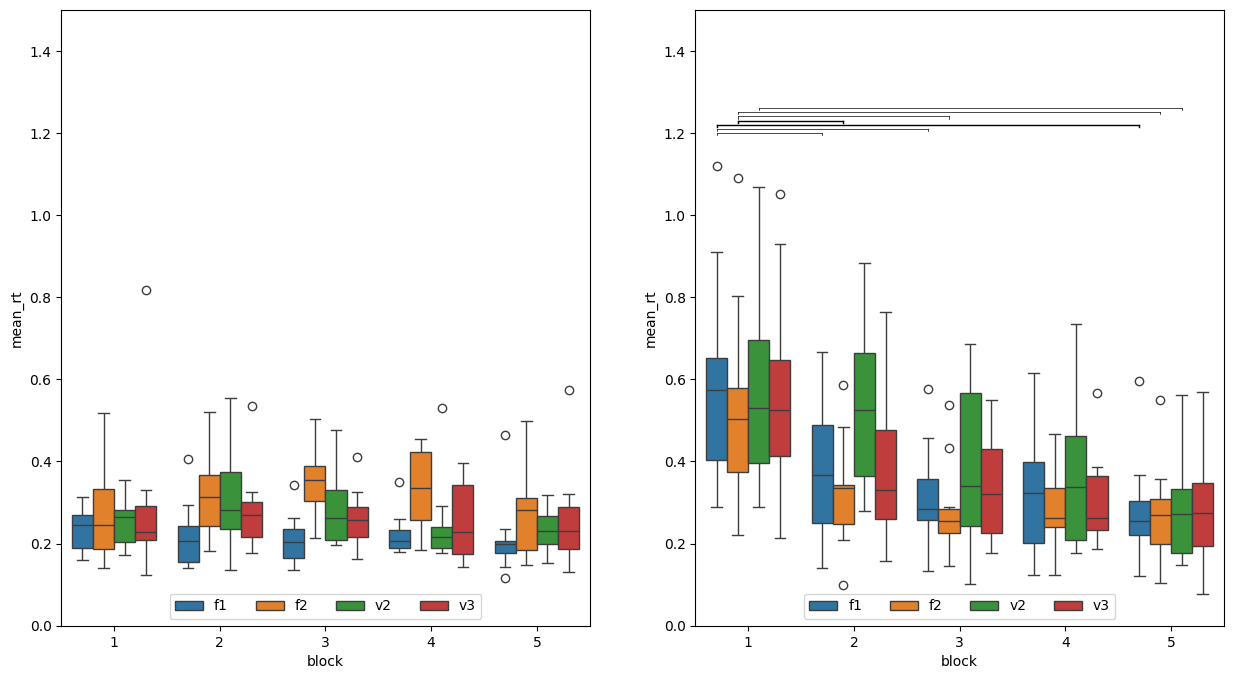

In [ ]:
# Graphics with significance bars
conditions = ['f1', 'f2', 'v2', 'v3']
fig, axes = plt.subplots(1, 2, figsize=(15,8))

# normal plot group 1

sns.boxplot(ax=axes[0], data=g1_data_summary, x="block", y="mean_rt", hue="stim_type")
axes[0].legend(ncol=4,loc='lower center')
axes[0].set(xlim=(-0.5,4.5))
axes[0].set(ylim=(-0,1.5))
pairw_forgraph = pairwise1[ pairwise1['p-corr'] < 0.05]

# Adding the significance bars for group 1

column_of_int = pairw_forgraph.columns.get_loc('constant')
shift_inc = 0
dip = 0.005
for i in range(pairw_forgraph.shape[0]):
    if pairw_forgraph.iloc[i, column_of_int] != '-':
        treatment_l = conditions.index(pairw_forgraph.iloc[i, column_of_int])
        treatment_r = treatment_l
        level_l = blocks.index(pairw_forgraph.iloc[i, pairw_forgraph.columns.get_loc('A')])
        level_r = blocks.index(pairw_forgraph.iloc[i, pairw_forgraph.columns.get_loc('B')])
        if pairw_forgraph.iloc[i, pairw_forgraph.columns.get_loc('p-corr')] > 0.01:
            lw = 0.5
        else:
            lw = 1
        add_sigbar(axes, grid_position=0, left_d=(level_l, treatment_l), right_d=(level_r, treatment_r), xfar_l=-0.5, h_thres=0.7, h_dip=dip, h_shift=shift_inc, line_width=lw)
        shift_inc += 3*dip


# normal plot group 2

sns.boxplot(ax=axes[1], data=g2_data_summary, x="block", y="mean_rt", hue="stim_type")
axes[1].legend(ncol=4,loc='lower center')
axes[1].set(xlim=(-0.5,4.5))
axes[1].set(ylim=(0,1.5))
pairw_forgraph = pairwise2[ pairwise2['p-corr'] < 0.05]

# Adding significance bars

column_of_int = pairw_forgraph.columns.get_loc('constant')
shift_inc = 0
dip = 0.005
for i in range(pairw_forgraph.shape[0]):
    if pairw_forgraph.iloc[i, column_of_int] != '-':
        treatment_l = conditions.index(pairw_forgraph.iloc[i, column_of_int])
        treatment_r = treatment_l
        level_l = blocks.index(pairw_forgraph.iloc[i, pairw_forgraph.columns.get_loc('A')])
        level_r = blocks.index(pairw_forgraph.iloc[i, pairw_forgraph.columns.get_loc('B')])
        if pairw_forgraph.iloc[i, pairw_forgraph.columns.get_loc('p-corr')] > 0.01:
            lw = 0.5
        else:
            lw = 1
        add_sigbar(axes, grid_position=1, left_d=(level_l, treatment_l), right_d=(level_r, treatment_r), xfar_l=-0.5, h_thres=1.2, h_dip=dip, h_shift=shift_inc, line_width=lw)
        shift_inc += 2*dip

## Comparing groups in a mixed model design

You should run the code until cell number [190] before running the code bellow.

The mixed model design assumes the following assumptions
- Normality for the between and within factors
- Homocedasticity for the between subjects factor
- Sphericity for the within subjects factor

In [ ]:
# Separating dataframes by group
data_bet_g1 = data.loc[ data['group'] == 1 , : ].reset_index(drop=True).drop(columns=['group'])
data_bet_g2 = data.loc[ data['group'] == 2 , : ].reset_index(drop=True).drop(columns=['group'])
data_bet_g1

,volunteer,block,stimuli,response,time,stim_type
0,1,1,1,1,0.385377,f1
1,1,1,2,2,0.160592,f2
2,1,1,2,2,0.333033,v2
3,1,1,1,1,0.329504,f1
4,1,1,2,2,0.255981,f2
...,...,...,...,...,...,...
7495,10,5,2,2,0.008328,f2
7496,10,5,2,2,0.125883,v2
7497,10,5,1,1,0.042673,f1
7498,10,5,2,2,0.013845,f2


In [ ]:
# Calculating the mean response times
conditions = ['f1', 'f2', 'v2', 'v3']

if 'dbet_g1' in locals():
    del dbet_g1
if 'dbet_g2' in locals():
    del dbet_g2

# group 1

exists_df = 0
volunteers = sorted(list(set(data_bet_g1['volunteer'])))
idx = 0
for v in volunteers:
    for c in conditions:
        c_data = data_bet_g1.loc[ data_bet_g1['volunteer'] == v, : ]
        c_data = c_data.loc[ data_bet_g1['stim_type'] == c, : ]
        c_dict = {'volunteer': v, 'stim_type': c, 'mean_rt': c_data['time'].mean()}
        if exists_df == 0:
            dbet_g1 = pd.DataFrame(c_dict, index=[idx])
            exists_df = 1
            idx +=1
        else:
            dbet_g1 = pd.concat([dbet_g1, pd.DataFrame(c_dict, index=[idx]) ], ignore_index=True)
            idx +=1

# group 2

exists_df = 0
volunteers = sorted(list(set(data_bet_g2['volunteer'])))
idx = 0
for v in volunteers:
    for c in conditions:
        c_data = data_bet_g2.loc[ data_bet_g2['volunteer'] == v, : ]
        c_data = c_data.loc[ data_bet_g2['stim_type'] == c, : ]
        c_dict = {'volunteer': v, 'stim_type': c, 'mean_rt': c_data['time'].mean()}
        if exists_df == 0:
            dbet_g2 = pd.DataFrame(c_dict, index=[idx])
            exists_df = 1
            idx +=1
        else:
            dbet_g2 = pd.concat([dbet_g2, pd.DataFrame(c_dict, index=[idx]) ], ignore_index=True)
            idx +=1

dbet_g1['group'] = [1]*dbet_g1.shape[0]
dbet_g2['group'] = [2]*dbet_g2.shape[0]
data_mixed = pd.concat([dbet_g1,dbet_g2]).reset_index()

In [ ]:
# Testing the assumptions

# Normality
norm_res_g1 = pg.normality(data_mixed.loc[ data_mixed['group'] == 1, :], dv='mean_rt', group= 'stim_type', method='shapiro', alpha=0.05)
norm_res_g2 = pg.normality(data_mixed.loc[ data_mixed['group'] == 2, :], dv='mean_rt', group= 'stim_type', method='shapiro', alpha=0.05)

# group 1 failed normality test

In [ ]:
# Reconstruction of the data with ranks
rdata_mixed = data_mixed.copy()
rdata_mixed['mean_rt'] = stats.rankdata(data_mixed['mean_rt'])

In [ ]:
# Testing the assumptions AGAIN

# Normality

ranked_norm_res_g1 = pg.normality(rdata_mixed.loc[ rdata_mixed['group'] == 1, :], dv='mean_rt', group= 'stim_type', method='shapiro', alpha=0.05)
ranked_norm_res_g2 = pg.normality(rdata_mixed.loc[ rdata_mixed['group'] == 2, :], dv='mean_rt', group= 'stim_type', method='shapiro', alpha=0.05)

# Both groups passed the normality test

# Homoscedasticity

ranked_homovar_res_g1 = pg.homoscedasticity(rdata_mixed.loc[ rdata_mixed['group'] == 1, :], dv='mean_rt', group= 'stim_type', method='levene', alpha=0.05)
ranked_homovar_res_g2 = pg.homoscedasticity(rdata_mixed.loc[ rdata_mixed['group'] == 2, :], dv='mean_rt', group= 'stim_type', method='levene', alpha=0.05)

# Both groups passed the homoscedasticity test

ranked_spher_res_g1 = pg.sphericity(rdata_mixed.loc[ rdata_mixed['group'] == 1, :], dv='mean_rt', within='stim_type', subject='volunteer', method='mauchly', alpha=0.05)
ranked_spher_res_g2 = pg.sphericity(rdata_mixed.loc[ rdata_mixed['group'] == 2, :], dv='mean_rt', within='stim_type', subject='volunteer', method='mauchly', alpha=0.05)

# Group 1 failed the sphericity test, but the mixed_anova is able to correct for the violation in sphericity

In [ ]:
# Checking the results of the Mixed ANOVA design

groups_comparison = pg.mixed_anova(data=rdata_mixed, dv='mean_rt', within='stim_type', subject='volunteer', between='group', correction='auto', effsize='np2')
groups_comparison

,Source,SS,DF1,DF2,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,group,9202.05,1,18,9202.050000,7.353976,0.014288,NaN,0.290052,NaN,NaN,NaN,NaN
1,stim_type,1450.30,3,54,483.433333,3.849360,0.014361,0.065006,0.176177,0.688238,False,0.380467,0.004331
2,Interaction,2702.45,3,54,900.816667,7.172795,0.000386,NaN,0.284942,NaN,NaN,NaN,NaN


In [ ]:
# Performing the pairwise comparisons

pw1 = pg.pairwise_tests(data=rdata_mixed, dv='mean_rt', between='group', within='stim_type', subject='volunteer', padjust='bonf').reset_index(drop=True)
pw2 = pg.pairwise_tests(data=rdata_mixed, dv='mean_rt', between='group', within='stim_type', subject='volunteer', within_first=False, padjust='bonf').reset_index(drop=True)
pw1 = pw1.rename(columns={'stim_type':'fix'})
pw2 = pw2.rename(columns={'group':'fix'})
pw_group_comparison = pd.concat([pw1, pw2]).reset_index()

In [ ]:
pw_group_comparison

,index,Contrast,fix,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,0,stim_type,-,f1,f2,True,True,-2.509989,19.0,two-sided,0.021287,0.127723,bonf,2.749,-0.486951
1,1,stim_type,-,f1,v2,True,True,-2.593998,19.0,two-sided,0.017812,0.106871,bonf,3.179,-0.335286
2,2,stim_type,-,f1,v3,True,True,-2.116157,19.0,two-sided,0.047759,0.286555,bonf,1.44,-0.330892
3,3,stim_type,-,f2,v2,True,True,0.503255,19.0,two-sided,0.620569,1.000000,bonf,0.26,0.114354
4,4,stim_type,-,f2,v3,True,True,0.745727,19.0,two-sided,0.464959,1.000000,bonf,0.298,0.158305
5,5,stim_type,-,v2,v3,True,True,0.299905,19.0,two-sided,0.767506,1.000000,bonf,0.242,0.029046
6,6,group,-,1,2,False,True,-2.711821,18.0,two-sided,0.014288,NaN,NaN,4.013,-1.161520
7,7,stim_type * group,f1,1,2,False,True,-3.712338,18.0,two-sided,0.001594,0.006377,bonf,20.775,-1.590058
8,8,stim_type * group,f2,1,2,False,True,-0.388269,18.0,two-sided,0.702371,1.000000,bonf,0.419,-0.166302
9,9,stim_type * group,v2,1,2,False,True,-3.271590,18.0,two-sided,0.004239,0.016955,bonf,9.796,-1.401278


In [ ]:
def add_sigbar2(axes, left_d, right_d, xfar_l, h_thres, h_dip, h_shift, line_width):
    level_l, treatment_l = left_d
    level_r, treatment_r = right_d
    a = xfar_l*(-1)/5 # half of a boxplot horizontal extension
    x = list()
    x.append( xfar_l + level_l + 2*a*(treatment_l+1) )
    x.append( xfar_l + level_r + 2*a*(treatment_r+1) )
    h_thres = h_thres + h_shift
    axes.plot( x, [h_thres]*2, color= 'k', lw = line_width)
    x_dip = np.ones(2)*x[0]
    y = np.array([h_thres, (h_thres - h_dip)])
    axes.plot( x_dip, y, color= 'k', lw = line_width)
    x_dip = np.ones(2)*x[1]
    y = np.array([h_thres, (h_thres - h_dip)])
    axes.plot( x_dip, y, color= 'k', lw = line_width)
    return

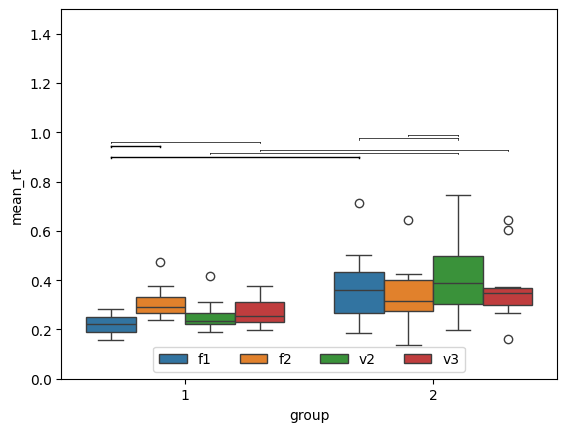

In [ ]:
# Creating the visualization for the pairwise comparison

fig, axes = plt.subplots()
sns.boxplot(ax=axes, data=data_mixed, x="group", y="mean_rt", hue="stim_type")
axes.legend(ncol=4,loc='lower center')
axes.set(xlim=(-0.5,1.5))
axes.set(ylim=(-0,1.5))
pairw_forgraph = pw_group_comparison[ pw_group_comparison['p-unc'] < 0.05]

groups = [1, 2]
# Adding the significance bars

column_of_int = pairw_forgraph.columns.get_loc('fix')
shift_inc = 0
dip = 0.005
for i in range(pairw_forgraph.shape[0]):
    if pairw_forgraph.iloc[i, column_of_int] != '-':
        try:
            treatment_l = conditions.index(pairw_forgraph.iloc[i, column_of_int])
            treatment_r = treatment_l
            level_l =groups.index(pairw_forgraph.iloc[i, pairw_forgraph.columns.get_loc('A')])
            level_r = groups.index(pairw_forgraph.iloc[i, pairw_forgraph.columns.get_loc('B')])
        except:
            level_l = groups.index(pairw_forgraph.iloc[i, column_of_int])
            level_r = level_l
            treatment_l = conditions.index(pairw_forgraph.iloc[i, pairw_forgraph.columns.get_loc('A')])
            treatment_r = conditions.index(pairw_forgraph.iloc[i, pairw_forgraph.columns.get_loc('B')])
        if pairw_forgraph.iloc[i, pairw_forgraph.columns.get_loc('p-corr')] > 0.01:
            lw = 0.5
        else:
            lw = 1
        add_sigbar2(axes, left_d=(level_l, treatment_l), right_d=(level_r, treatment_r), xfar_l=-0.5, h_thres=0.9, h_dip=dip, h_shift=shift_inc, line_width=lw)
        shift_inc += 3*dip


In [ ]:
pairw_forgraph

,index,Contrast,fix,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,0,stim_type,-,f1,f2,True,True,-2.509989,19.0,two-sided,0.021287,0.127723,bonf,2.749,-0.486951
1,1,stim_type,-,f1,v2,True,True,-2.593998,19.0,two-sided,0.017812,0.106871,bonf,3.179,-0.335286
2,2,stim_type,-,f1,v3,True,True,-2.116157,19.0,two-sided,0.047759,0.286555,bonf,1.44,-0.330892
6,6,group,-,1,2,False,True,-2.711821,18.0,two-sided,0.014288,NaN,NaN,4.013,-1.161520
7,7,stim_type * group,f1,1,2,False,True,-3.712338,18.0,two-sided,0.001594,0.006377,bonf,20.775,-1.590058
9,9,stim_type * group,v2,1,2,False,True,-3.271590,18.0,two-sided,0.004239,0.016955,bonf,9.796,-1.401278
10,10,stim_type * group,v3,1,2,False,True,-2.129001,18.0,two-sided,0.047317,0.189268,bonf,1.763,-0.911888
11,0,group,-,1,2,False,True,-2.711821,18.0,two-sided,0.014288,NaN,NaN,4.013,-1.161520
12,1,stim_type,-,f1,f2,True,True,-2.509989,19.0,two-sided,0.021287,0.127723,bonf,2.749,-0.486951
13,2,stim_type,-,f1,v2,True,True,-2.593998,19.0,two-sided,0.017812,0.106871,bonf,3.179,-0.335286


## Comparing stimulus type depending on the previous stimuly

We are using again a 2-way repeated measures ANOVA design

In [ ]:
# Identifying the previous variable step

var_conds = ['v2', 'v3']

prev = list()
for l in range(data.shape[0]):
    step_back = l;
    if (l-1) < 0:
        prev.append('none')
    else:
        while step_back >= 0:
            step_back -= 1
            if data['volunteer'].iloc[step_back] == data['volunteer'].iloc[l]:
                if data['stim_type'].iloc[step_back] in var_conds:
                    prev.append(data['stim_type'].iloc[step_back])
                    break
            else:
                prev.append('none')
                break
data['prev'] = pd.DataFrame(prev)

In [ ]:
# Calculating the mean response time per volunteer/stimulus_type/previous

if 'prev_data_g1' in locals():
    del prev_data_g1

if 'prev_data_g2' in locals():
    del prev_data_g2

# group 1

data_g1 = data.loc[data['group'] == 1,:]

volunteers = list(set(data_g1['volunteer']))
cond_stim = ('f1','f2','v2', 'v3')
cond_prev = ('v2', 'v3')
exists_df = 0
for v in volunteers:
    for s in cond_stim:
        for p in cond_prev:
            data_slice = data.loc[data['volunteer'] == v,:]
            data_slice = data_slice.loc[data_slice['stim_type'] == s,:]
            data_slice = data_slice.loc[data_slice['prev'] == p,:]
            if exists_df == 0:
                prev_data_g1 = pd.DataFrame.from_records({'volunteer': v, 'stim_type': s, 'prev': p, 'mean_rt': data_slice['time'].mean()},index=[0])
                exists_df = 1
            else:
                idx = prev_data_g1.shape[0]
                pre_input = pd.DataFrame.from_records({'volunteer': v, 'stim_type': s, 'prev': p, 'mean_rt': data_slice['time'].mean()},index=[idx])
                prev_data_g1 = pd.concat([prev_data_g1, pre_input])

# group 2

data_g2 = data.loc[data['group'] == 2,:]

volunteers = list(set(data_g2['volunteer']))
cond_stim = ('f1','f2','v2', 'v3')
cond_prev = ('v2', 'v3')
exists_df = 0
for v in volunteers:
    for s in cond_stim:
        for p in cond_prev:
            data_slice = data.loc[data['volunteer'] == v,:]
            data_slice = data_slice.loc[data_slice['stim_type'] == s,:]
            data_slice = data_slice.loc[data_slice['prev'] == p,:]
            if exists_df == 0:
                prev_data_g2 = pd.DataFrame.from_records({'volunteer': v, 'stim_type': s, 'prev': p, 'mean_rt': data_slice['time'].mean()},index=[0])
                exists_df = 1
            else:
                idx = prev_data_g2.shape[0]
                pre_input = pd.DataFrame.from_records({'volunteer': v, 'stim_type': s, 'prev': p, 'mean_rt': data_slice['time'].mean()},index=[idx])
                prev_data_g2 = pd.concat([prev_data_g2, pre_input])

In [ ]:
# Checking the output

prev_data_g1

,mean_rt,prev,stim_type,volunteer
0,0.300289,v2,f1,1
1,0.223238,v3,f1,1
2,0.227970,v2,f2,1
3,0.271269,v3,f2,1
4,0.343110,v2,v2,1
...,...,...,...,...
75,0.512678,v3,f2,10
76,0.188305,v2,v2,10
77,0.185356,v3,v2,10
78,0.212563,v2,v3,10


In [ ]:
# # Visualizing the data

# fig, axes = plt.subplots(1, 2, figsize=(10,5))
# sns.boxplot(ax=axes[0], data=prev_data_g1, x="prev", y="mean_rt", hue="stim_type")
# axes[0].set(ylim=(0, 1))
# sns.boxplot(ax=axes[1], data=prev_data_g2, x="prev", y="mean_rt", hue="stim_type")
# axes[1].set(ylim=(0, 1))

In [ ]:
# Testing assumtions of normality for the upcomping repeated measures ANOVA

# testing normality

# Group1
g1_res_norm_1 = pg.normality(prev_data_g1.loc[ prev_data_g1['prev'] == cond_prev[0], :], dv='mean_rt', group= 'stim_type', method='shapiro', alpha=0.05)
g1_res_norm_2 = pg.normality(prev_data_g1.loc[ prev_data_g1['prev'] == cond_prev[1], :], dv='mean_rt', group= 'stim_type', method='shapiro', alpha=0.05)

# Group2
g2_res_norm_1 = pg.normality(prev_data_g2.loc[ prev_data_g2['prev'] == cond_prev[0], :], dv='mean_rt', group= 'stim_type', method='shapiro', alpha=0.05)
g2_res_norm_2 = pg.normality(prev_data_g2.loc[ prev_data_g2['prev'] == cond_prev[1], :], dv='mean_rt', group= 'stim_type', method='shapiro', alpha=0.05)



In [ ]:
# No need for testing sphericity given the test is applied automatically with pingouin function

g1_res_rm = pg.rm_anova(data=prev_data_g1, dv='mean_rt', within=['stim_type','prev' ], subject='volunteer', correction='auto')
g2_res_rm = pg.rm_anova(data=prev_data_g2, dv='mean_rt', within=['stim_type','prev' ], subject='volunteer', correction='auto')

# Both had significant results

/usr/local/lib/python3.10/dist-packages/pingouin/distribution.py:507: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  data.groupby(level=1, axis=1, observed=True, group_keys=False)
/usr/local/lib/python3.10/dist-packages/pingouin/distribution.py:507: FutureWarning: DataFrameGroupBy.diff with axis=1 is deprecated and will be removed in a future version. Operate on the un-grouped DataFrame instead
  data.groupby(level=1, axis=1, observed=True, group_keys=False)
/usr/local/lib/python3.10/dist-packages/pingouin/distribution.py:507: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  data.groupby(level=1, axis=1, observed=True, group_keys=False)
/usr/local/lib/python3.10/dist-packages/pingouin/distribution.py:507: FutureWarning: DataFrameGroupBy.diff with axis=1 is deprecated and will be removed in a future version. Operate on the un-grouped DataFrame instead
  data.groupb

In [ ]:
# Results of the 2-way repeated measures ANOVA design

# Group 1

g1_res_rm

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,stim_type,0.044740,3,27,0.014913,3.313823,0.034877,0.082849,0.116996,0.463297
1,prev,0.002404,1,9,0.002404,1.009784,0.341206,0.341206,0.007071,1.000000
2,stim_type * prev,0.033684,3,27,0.011228,6.169175,0.002476,0.004296,0.090707,0.858045


In [ ]:
# Results of the 2-way repeated measures ANOVA design

# Group 2

g2_res_rm

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,stim_type,0.045504,3,27,0.015168,3.334590,0.034155,0.068600,0.024576,0.571018
1,prev,0.006072,1,9,0.006072,1.526013,0.247986,0.247986,0.003350,1.000000
2,stim_type * prev,0.055868,3,27,0.018623,13.216415,0.000017,0.000157,0.030005,0.739230


In [ ]:
# Performig the pairwise comparisons

# group 1

pw1_prevA = pg.pairwise_tests(data=prev_data_g1, dv='mean_rt', within=['stim_type', 'prev'], subject='volunteer', padjust='bonf').reset_index(drop=True)
pw1_prevB = pg.pairwise_tests(data=prev_data_g1, dv='mean_rt', within=['prev', 'stim_type'], subject='volunteer', padjust='bonf').reset_index(drop=True)
pw1_prevA = pw1_prevA.rename(columns={'stim_type':'fix'})
pw1_prevB = pw1_prevB.rename(columns={'prev':'fix'})
pw1_prevB['fix'] = pw1_prevB['fix'].replace({'v2': 'V2', 'v3':'V3'})
pw1_prev = pd.concat([pw1_prevA, pw1_prevB]).reset_index()
pw1_prev = pw1_prev.drop(columns=['index']).drop_duplicates().reset_index()
pw1_prev = pw1_prev.drop(columns=['index'])

# group 2
pw2_prevA = pg.pairwise_tests(data=prev_data_g2, dv='mean_rt', within=['stim_type', 'prev'], subject='volunteer', padjust='bonf').reset_index(drop=True)
pw2_prevB = pg.pairwise_tests(data=prev_data_g2, dv='mean_rt', within=['prev', 'stim_type'], subject='volunteer', padjust='bonf').reset_index(drop=True)
pw2_prevA = pw2_prevA.rename(columns={'stim_type':'fix'})
pw2_prevB = pw2_prevB.rename(columns={'prev':'fix'})
pw2_prevB['fix'] = pw2_prevB['fix'].replace({'v2': 'V2', 'v3':'V3'})
pw2_prev = pd.concat([pw2_prevA, pw2_prevB]).reset_index()
pw2_prev = pw2_prev.drop(columns=['index']).drop_duplicates().reset_index()
pw2_prev = pw2_prev.drop(columns=['index'])


In [ ]:
# Pairwise comparisons for group 1

pw1_prev

,Contrast,fix,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,stim_type,-,f1,f2,True,True,-3.441234,9.0,two-sided,0.007376,0.044257,bonf,7.917,-1.148951
1,stim_type,-,f1,v2,True,True,-1.298951,9.0,two-sided,0.226251,1.000000,bonf,0.601,-0.407638
2,stim_type,-,f1,v3,True,True,-2.187394,9.0,two-sided,0.056490,0.338938,bonf,1.608,-0.617024
3,stim_type,-,f2,v2,True,True,1.427451,9.0,two-sided,0.187212,1.000000,bonf,0.681,0.610475
4,stim_type,-,f2,v3,True,True,1.051951,9.0,two-sided,0.320245,1.000000,bonf,0.484,0.435229
5,stim_type,-,v2,v3,True,True,-1.630891,9.0,two-sided,0.137350,0.824102,bonf,0.842,-0.173912
6,prev,-,v2,v3,True,True,-1.004880,9.0,two-sided,0.341206,NaN,NaN,0.467,-0.218038
7,stim_type * prev,f1,v2,v3,True,True,2.966780,9.0,two-sided,0.015785,0.063139,bonf,4.31,1.016544
8,stim_type * prev,f2,v2,v3,True,True,-3.638019,9.0,two-sided,0.005418,0.021670,bonf,10.163,-0.824656
9,stim_type * prev,v2,v2,v3,True,True,-1.339042,9.0,two-sided,0.213392,0.853567,bonf,0.625,-0.341446


In [ ]:
# Pairwise comparisons for group 2

pw2_prev

,Contrast,fix,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,stim_type,-,f1,f2,True,True,2.533318,9.0,two-sided,0.032060,0.192362,bonf,2.476,0.241356
1,stim_type,-,f1,v2,True,True,-1.343266,9.0,two-sided,0.212074,1.000000,bonf,0.627,-0.162058
2,stim_type,-,f1,v3,True,True,-0.596043,9.0,two-sided,0.565833,1.000000,bonf,0.359,-0.062503
3,stim_type,-,f2,v2,True,True,-3.483199,9.0,two-sided,0.006904,0.041422,bonf,8.352,-0.412083
4,stim_type,-,f2,v3,True,True,-2.283293,9.0,two-sided,0.048302,0.289810,bonf,1.809,-0.312567
5,stim_type,-,v2,v3,True,True,0.545966,9.0,two-sided,0.598360,1.000000,bonf,0.351,0.102426
6,prev,-,v2,v3,True,True,1.235319,9.0,two-sided,0.247986,NaN,NaN,0.567,0.110393
7,stim_type * prev,f1,v2,v3,True,True,2.830323,9.0,two-sided,0.019712,0.078848,bonf,3.617,0.250341
8,stim_type * prev,f2,v2,v3,True,True,1.386670,9.0,two-sided,0.198924,0.795698,bonf,0.654,0.145647
9,stim_type * prev,v2,v2,v3,True,True,-2.745312,9.0,two-sided,0.022650,0.090599,bonf,3.244,-0.383232


In [ ]:
def add_sigbar3(axes, grid_position, left_d, right_d, xfar_l, h_thres, h_dip, h_shift, line_width):
    level_l, treatment_l = left_d
    level_r, treatment_r = right_d
    a = xfar_l*(-1)/5 # half of a boxplot horizontal extension
    x = list()
    x.append( xfar_l + level_l + 2*a*(treatment_l+1) )
    x.append( xfar_l + level_r + 2*a*(treatment_r+1) )
    h_thres = h_thres + h_shift
    axes[grid_position].plot( x, [h_thres]*2, color= 'k', lw = line_width)
    x_dip = np.ones(2)*x[0]
    y = np.array([h_thres, (h_thres - h_dip)])
    axes[grid_position].plot( x_dip, y, color= 'k', lw = line_width)
    x_dip = np.ones(2)*x[1]
    y = np.array([h_thres, (h_thres - h_dip)])
    axes[grid_position].plot( x_dip, y, color= 'k', lw = line_width)
    return

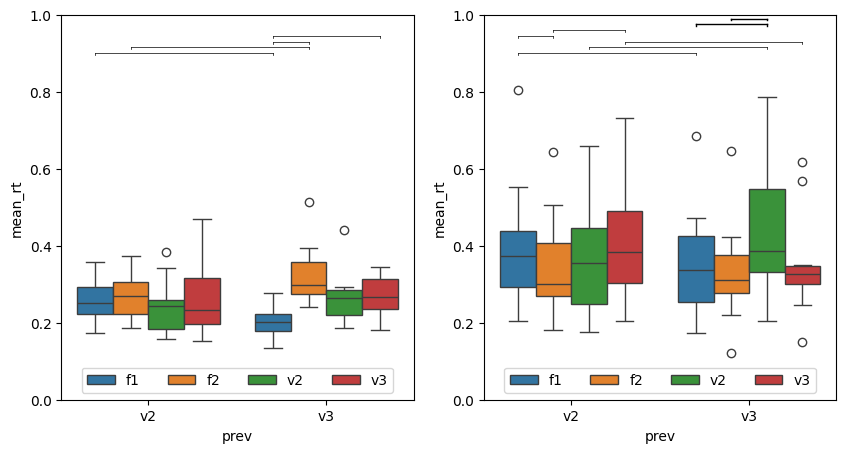

In [ ]:
# Creating the visualization for the pairwise comparison

fig, axes = plt.subplots(1, 2, figsize=(10,5))
sns.boxplot(ax=axes[0], data=prev_data_g1, x="prev", y="mean_rt", hue="stim_type")
axes[0].set(ylim=(0, 1))
axes[0].legend(ncol=4,loc='lower center')
sns.boxplot(ax=axes[1], data=prev_data_g2, x="prev", y="mean_rt", hue="stim_type")
axes[1].set(ylim=(0, 1))
axes[1].legend(ncol=4,loc='lower center')

pairw_forgraph1 = pw1_prev[ pw1_prev['p-unc'] < 0.05]
pairw_forgraph2 = pw2_prev[ pw2_prev['p-unc'] < 0.05]


groups = ['V2', 'V3']
conditions = ['f1','f2','v2', 'v3']

# Adding the significance bars in group 1

column_of_int = pairw_forgraph1.columns.get_loc('fix')
shift_inc = 0
dip = 0.005
for i in range(pairw_forgraph1.shape[0]):
    if pairw_forgraph1.iloc[i, column_of_int] != '-':
        if pairw_forgraph1.iloc[i,column_of_int] in conditions:
            treatment_l = conditions.index(pairw_forgraph1.iloc[i, column_of_int])
            treatment_r = treatment_l
            level_l = groups.index(pairw_forgraph1.iloc[i, pairw_forgraph1.columns.get_loc('A')].upper())
            level_r = groups.index(pairw_forgraph1.iloc[i, pairw_forgraph1.columns.get_loc('B')].upper())
        else:
            level_l = groups.index(pairw_forgraph1.iloc[i, column_of_int])
            level_r = level_l
            treatment_l = conditions.index(pairw_forgraph1.iloc[i, pairw_forgraph1.columns.get_loc('A')])
            treatment_r = conditions.index(pairw_forgraph1.iloc[i, pairw_forgraph1.columns.get_loc('B')])
        if pairw_forgraph1.iloc[i, pairw_forgraph1.columns.get_loc('p-corr')] > 0.01:
            lw = 0.5
        else:
            lw = 1
        add_sigbar3(axes, grid_position = 0, left_d=(level_l, treatment_l), right_d=(level_r, treatment_r), xfar_l=-0.5, h_thres=0.9, h_dip=dip, h_shift=shift_inc, line_width=lw)
        shift_inc += 3*dip

# Adding the significance bars in group 2

column_of_int = pairw_forgraph2.columns.get_loc('fix')
shift_inc = 0
dip = 0.005
for i in range(pairw_forgraph2.shape[0]):
    if pairw_forgraph2.iloc[i, column_of_int] != '-':
        if pairw_forgraph2.iloc[i,column_of_int] in conditions:
            treatment_l = conditions.index(pairw_forgraph2.iloc[i, column_of_int])
            treatment_r = treatment_l
            level_l = groups.index(pairw_forgraph2.iloc[i, pairw_forgraph2.columns.get_loc('A')].upper())
            level_r = groups.index(pairw_forgraph2.iloc[i, pairw_forgraph2.columns.get_loc('B')].upper())
        else:
            level_l = groups.index(pairw_forgraph2.iloc[i, column_of_int])
            level_r = level_l
            treatment_l = conditions.index(pairw_forgraph2.iloc[i, pairw_forgraph2.columns.get_loc('A')])
            treatment_r = conditions.index(pairw_forgraph2.iloc[i, pairw_forgraph2.columns.get_loc('B')])
        if pairw_forgraph2.iloc[i, pairw_forgraph2.columns.get_loc('p-unc')] > 0.01:
            lw = 0.5
        else:
            lw = 1
        add_sigbar3(axes, grid_position = 1, left_d=(level_l, treatment_l), right_d=(level_r, treatment_r), xfar_l=-0.5, h_thres=0.9, h_dip=dip, h_shift=shift_inc, line_width=lw)
        shift_inc += 3*dip


In [ ]:
pairw_forgraph2

,Contrast,fix,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,stim_type,-,f1,f2,True,True,2.533318,9.0,two-sided,0.032060,0.192362,bonf,2.476,0.241356
3,stim_type,-,f2,v2,True,True,-3.483199,9.0,two-sided,0.006904,0.041422,bonf,8.352,-0.412083
4,stim_type,-,f2,v3,True,True,-2.283293,9.0,two-sided,0.048302,0.289810,bonf,1.809,-0.312567
7,stim_type * prev,f1,v2,v3,True,True,2.830323,9.0,two-sided,0.019712,0.078848,bonf,3.617,0.250341
9,stim_type * prev,v2,v2,v3,True,True,-2.745312,9.0,two-sided,0.022650,0.090599,bonf,3.244,-0.383232
10,stim_type * prev,v3,v2,v3,True,True,3.101411,9.0,two-sided,0.012694,0.050774,bonf,5.124,0.440918
11,prev * stim_type,V2,f1,f2,True,True,2.348552,9.0,two-sided,0.043408,0.520895,bonf,1.962,0.295292
15,prev * stim_type,V2,f2,v3,True,True,-2.671707,9.0,two-sided,0.025551,0.306611,bonf,2.952,-0.446230
18,prev * stim_type,V3,f1,v2,True,True,-3.572144,9.0,two-sided,0.006004,0.072049,bonf,9.35,-0.476633
20,prev * stim_type,V3,f2,v2,True,True,-3.688983,9.0,two-sided,0.005005,0.060063,bonf,10.838,-0.649401
